# Map onehot features to linear space


In [1]:
# Imports
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

In [2]:
# Import custom code
from flightdelay.fld import io as flio

# Load data

In [3]:
airlines_df, airports_df, flights_df = flio.load_data()

In [4]:
# Filter data to keys of interest
keys = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']
flights_df = flights_df[keys]

# Remove airports with less than a certain number of flights

In [5]:
all_airports, airport_inverse, airport_count = np.unique(flights_df['ORIGIN_AIRPORT'],return_counts=True,return_inverse=True)

In [6]:
# Determine number of flights for the origin airport
Nflights_orig = np.zeros(len(airport_inverse))
for i in range(len(all_airports)):
    Nflights_orig[np.where(airport_inverse==i)] = airport_count[i]

In [7]:
flights_df = flights_df.loc[flights_df.index[Nflights_orig>=7300]]

In [8]:
len(flights_df)

5342006

# Remove cancelled flights

In [9]:
flights_df = flights_df.dropna()
flights_df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,...,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,...,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0
2,1,1,4,US,840,N171US,SFO,CLT,20,18.0,...,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0
3,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,...,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0
4,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,...,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0


# Make train and val set

In [42]:
N_flights = len(flights_df)
N_train = int(N_flights*.7)
np.random.seed(0)
flight_take_idx = np.random.permutation(flights_df.index)[:N_flights]
df_trainval = flights_df.loc[flight_take_idx]

In [43]:
df_trainval.head(20)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
3783504,8,23,7,WN,285,N7738A,MCI,DEN,1410,1408.0,...,1414.0,105.0,95.0,83.0,533,1437.0,6.0,1455,1443.0,-12.0
5412589,12,5,6,AS,335,N520AS,SJC,SEA,1550,1534.0,...,1554.0,120.0,135.0,105.0,697,1739.0,10.0,1750,1749.0,-1.0
5347613,12,1,2,UA,1750,N76254,SAN,IAH,1314,1354.0,...,1406.0,188.0,168.0,148.0,1303,1834.0,8.0,1822,1842.0,20.0
2383329,5,31,7,WN,396,N8318F,AUS,DEN,1935,2039.0,...,2051.0,140.0,128.0,109.0,775,2140.0,7.0,2055,2147.0,52.0
2817074,6,26,5,EV,4899,N133EV,ATL,MYR,1454,1509.0,...,1533.0,85.0,77.0,49.0,317,1622.0,4.0,1619,1626.0,7.0
5428910,12,6,7,OO,5236,N756SK,ORD,OKC,1913,1925.0,...,1949.0,133.0,121.0,91.0,693,2120.0,6.0,2126,2126.0,0.0
4073892,9,10,4,HA,516,N484HA,HNL,OGG,2150,2144.0,...,2155.0,38.0,41.0,23.0,100,2218.0,7.0,2228,2225.0,-3.0
2296450,5,26,2,EV,6176,N12996,EWR,GSO,1306,1318.0,...,1330.0,99.0,85.0,68.0,445,1438.0,5.0,1445,1443.0,-2.0
1182922,3,18,3,WN,1969,N932WN,TPA,MDW,1330,1330.0,...,1344.0,160.0,159.0,141.0,997,1505.0,4.0,1510,1509.0,-1.0
5228455,11,23,1,WN,2375,N8323C,IND,TPA,1545,1546.0,...,1555.0,135.0,119.0,105.0,837,1740.0,5.0,1800,1745.0,-15.0


# Split data by airport

In [44]:
all_aps = np.unique(df_trainval['ORIGIN_AIRPORT'])
N_aps = len(all_aps)

In [45]:
dfbyap = {}
for ap in all_aps:
    dfbyap[ap] = df_trainval[df_trainval['ORIGIN_AIRPORT'].values==ap]

In [46]:
dfbyap['SAN']

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
5347613,12,1,2,UA,1750,N76254,SAN,IAH,1314,1354.0,...,1406.0,188.0,168.0,148.0,1303,1834.0,8.0,1822,1842.0,20.0
1359513,3,29,7,B6,620,N705JB,SAN,BOS,1119,1112.0,...,1140.0,321.0,316.0,284.0,2588,1924.0,4.0,1940,1928.0,-12.0
1962697,5,5,2,US,486,N548UW,SAN,PHX,1615,1603.0,...,1624.0,75.0,84.0,51.0,304,1715.0,12.0,1730,1727.0,-3.0
4436101,10,4,7,AS,760,N453AS,SAN,MCO,1020,1027.0,...,1043.0,275.0,276.0,254.0,2149,1757.0,6.0,1755,1803.0,8.0
2613698,6,14,7,WN,663,N399WN,SAN,PHX,1625,1723.0,...,1730.0,70.0,65.0,53.0,304,1823.0,5.0,1735,1828.0,53.0
2582184,6,12,5,WN,330,N8657B,SAN,DEN,1625,1630.0,...,1637.0,140.0,122.0,110.0,853,1927.0,5.0,1945,1932.0,-13.0
4139781,9,15,2,OO,3485,N219AG,SAN,SLC,1045,1521.0,...,1559.0,112.0,122.0,80.0,626,1819.0,4.0,1337,1823.0,286.0
1834959,4,27,1,UA,1449,N14214,SAN,DEN,1750,1747.0,...,1801.0,140.0,142.0,121.0,853,2102.0,7.0,2110,2109.0,-1.0
4018567,9,7,1,B6,190,N559JB,SAN,JFK,1252,1247.0,...,1259.0,330.0,293.0,278.0,2446,2037.0,3.0,2122,2040.0,-42.0
5425884,12,6,7,UA,450,N431UA,SAN,SFO,1607,1658.0,...,1709.0,98.0,90.0,67.0,447,1816.0,12.0,1745,1828.0,43.0


# Compute features

### 0. Binary delay

In [47]:
for ap in all_aps:
    dfbyap[ap]['y'] = dfbyap[ap]['DEPARTURE_DELAY'].values>15

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### 1. Day of week

In [58]:
# Calculate number of flights departing that airport on each day of the week
days_pop = {}
for ap in all_aps:
    # Find prevalence of each day of week
    unique_days, days_counts = np.unique(dfbyap[ap]['DAY_OF_WEEK'],return_counts=True)
    days_pop[ap] = dict(zip(unique_days, days_counts))
    dfbyap[ap]['daypop'] = dfbyap[ap]['DAY_OF_WEEK'].map(days_pop[ap])

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.44113538930600438, 0.32179358951088505)


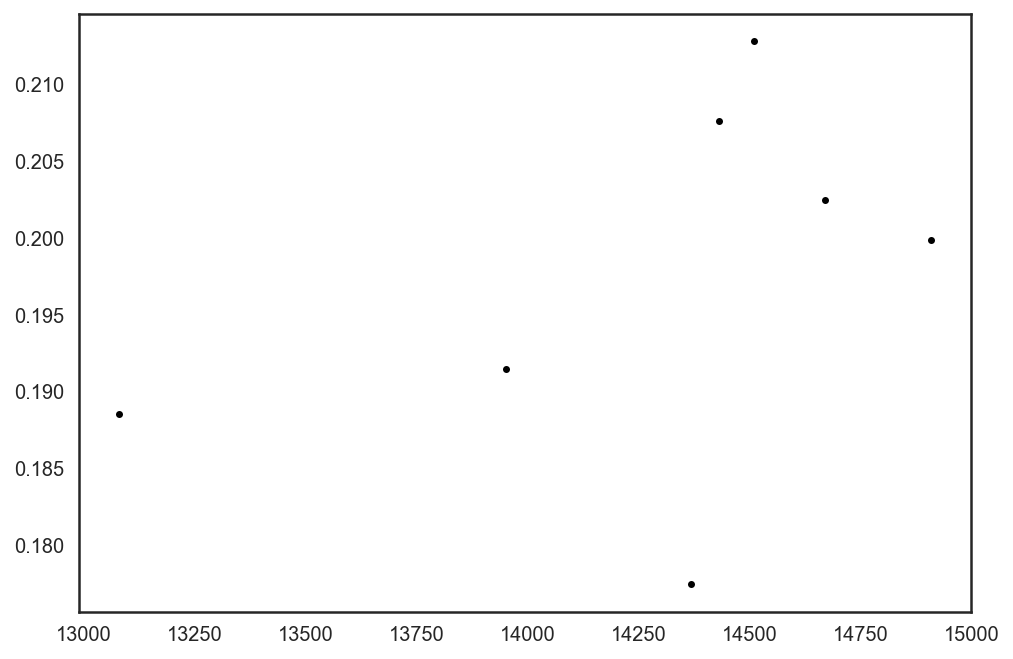

In [59]:
# Calculate mean delay for each day of the week
ap = 'JFK'
delaybyday = {}
for d in unique_days:
    delaybyday[d] = np.mean(dfbyap[ap][dfbyap[ap]['DAY_OF_WEEK']==d]['y'])
    
print(sp.stats.pearsonr(list(days_pop[ap].values()),list(delaybyday.values())))
plt.plot(list(days_pop[ap].values()),list(delaybyday.values()),'k.')

### 2. Month

In [56]:
# Calculate number of flights departing that airport on each day of the week
months_pop = {}
for ap in all_aps:
    # Find prevalence of each day of week
    unique_months, months_counts = np.unique(dfbyap[ap]['MONTH'],return_counts=True)
    months_pop[ap] = dict(zip(unique_months, months_counts))
    dfbyap[ap]['monthpop'] = dfbyap[ap]['MONTH'].map(months_pop[ap])

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.310255596285548, 0.32636647029193755)


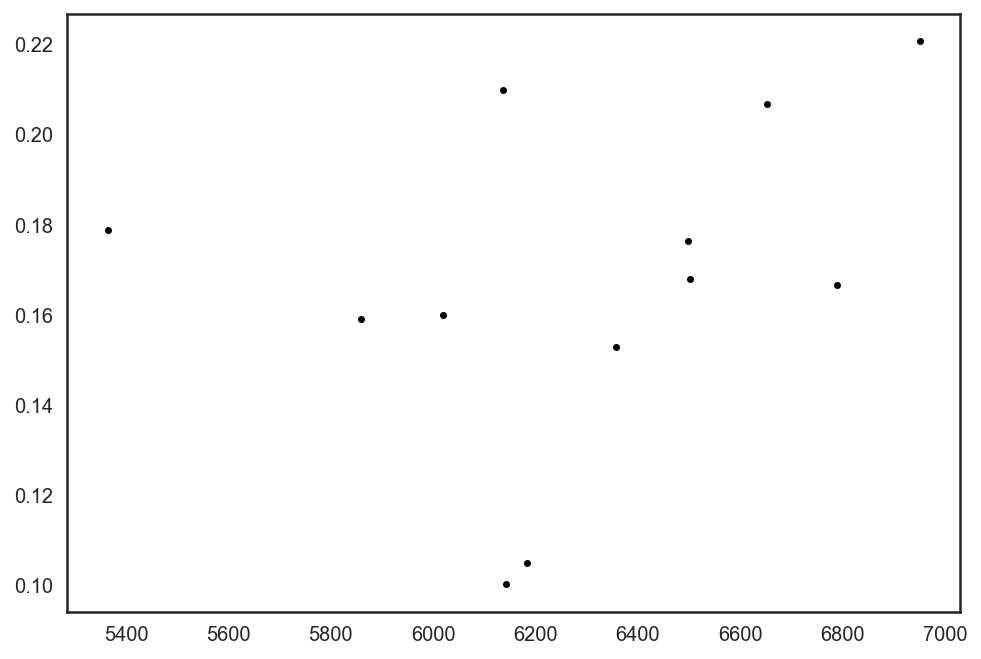

In [62]:
# Calculate mean delay for each day of the week
ap = 'SAN'
delaybymonth = {}
for d in unique_months:
    delaybymonth[d] = np.mean(dfbyap[ap][dfbyap[ap]['MONTH']==d]['y'])
    
print(sp.stats.pearsonr(list(months_pop[ap].values()),list(delaybymonth.values())))
plt.plot(list(months_pop[ap].values()),list(delaybymonth.values()),'k.')

### 4. Airline

In [76]:
# Calculate number of flights departing that airport on each day of the week
airline_pop = {}
unique_airline = {}
for ap in all_aps:
    # Find prevalence of each day of week
    unique_airline[ap], airline_counts = np.unique(dfbyap[ap]['AIRLINE'],return_counts=True)
    airline_pop[ap] = dict(zip(unique_airline[ap], airline_counts))
    dfbyap[ap]['airlinepop'] = dfbyap[ap]['AIRLINE'].map(airline_pop[ap])

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.31334417099031303, 0.32131767837165437)


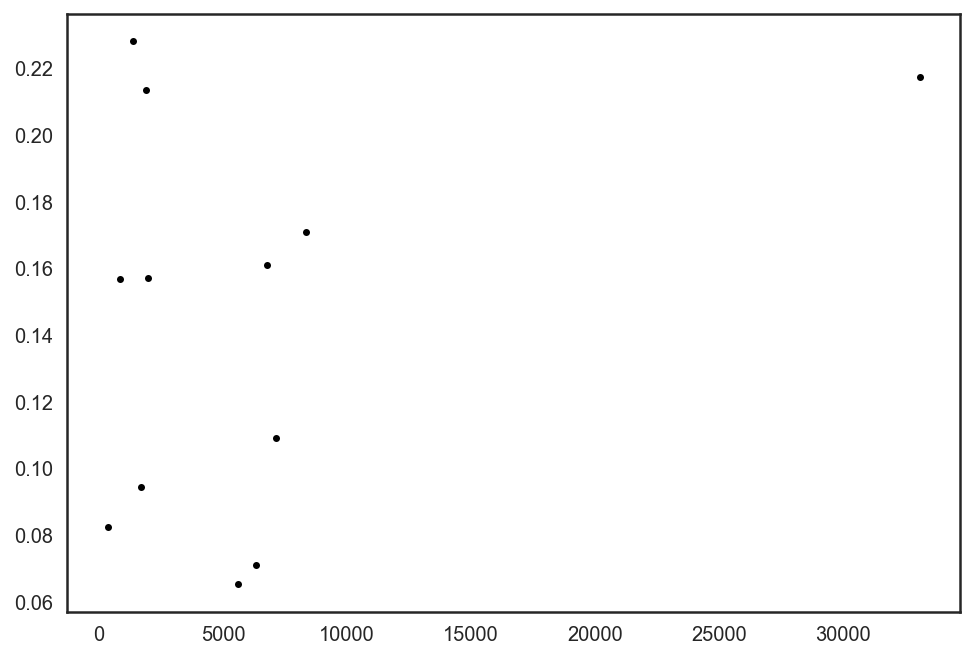

In [77]:
# Calculate mean delay for each day of the week
ap = 'SAN'
delaybyairline = {}
for d in unique_airline[ap]:
    delaybyairline[d] = np.mean(dfbyap[ap][dfbyap[ap]['AIRLINE']==d]['y'])
    
print(sp.stats.pearsonr(list(airline_pop[ap].values()),list(delaybyairline.values())))
plt.plot(list(airline_pop[ap].values()),list(delaybyairline.values()),'k.')

### 5. Departure hour

In [80]:
# Add departure hour as a feature

# Calculate number of flights departing that airport on each day of the week
hr_pop = {}
unique_hr = {}
for ap in all_aps:
    # Find prevalence of each day of week
    dfbyap[ap]['HOUR_DEPARTURE'] = np.floor(dfbyap[ap]['SCHEDULED_DEPARTURE'].values/100).astype(int)
    unique_hr[ap], hr_counts = np.unique(dfbyap[ap]['HOUR_DEPARTURE'],return_counts=True)
    hr_pop[ap] = dict(zip(unique_hr, hr_counts))
    dfbyap[ap]['hrpop'] = dfbyap[ap]['HOUR_DEPARTURE'].map(hr_pop[ap])

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(-0.28183419406294857, 0.24241472325507968)


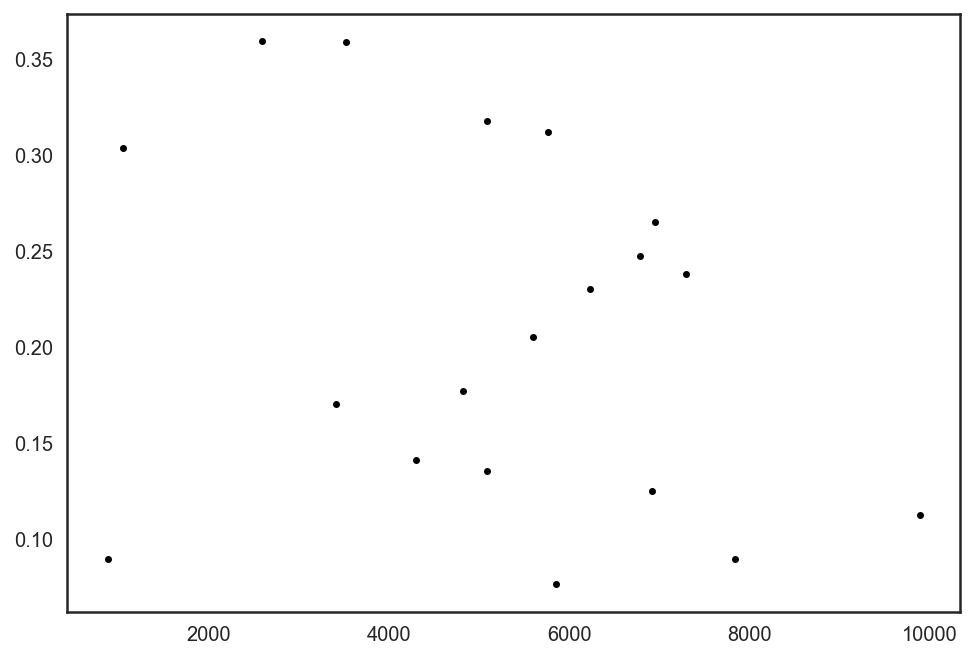

In [82]:
# Calculate mean delay for each day of the week
ap = 'JFK'
delaybyhr = {}
for d in unique_hr[ap]:
    delaybyhr[d] = np.mean(dfbyap[ap][dfbyap[ap]['HOUR_DEPARTURE']==d]['y'])
    
print(sp.stats.pearsonr(list(hr_pop[ap].values()),list(delaybyhr.values())))
plt.plot(list(hr_pop[ap].values()),list(delaybyhr.values()),'k.')

# Save new feature matrix

In [20]:
all_dicts = [original_feat, daysfeat_dict, monthsfeat_dict, dapfeat_dict, alfeat_dict, hrfeat_dict]
feat_dict = all_dicts[0].copy()
for d in all_dicts[1:]:
    feat_dict.update(d)

In [21]:
df_feat = pd.DataFrame.from_dict(feat_dict)
df_feat.head()

,f_al_AA,f_al_AS,f_al_B6,f_al_DL,f_al_EV,f_al_F9,f_al_HA,f_al_MQ,f_al_NK,f_al_OO,...,f_month_10,f_month_11,f_month_2,f_month_3,f_month_4,f_month_5,f_month_6,f_month_7,f_month_8,f_month_9
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


# Train model for each airport

In [64]:
# zscore all features
from scipy.stats import zscore
df_feat_zscore = df_feat.apply(zscore)

In [66]:
all_models = {}
all_X_train = {}
all_X_val = {}
all_y_train = {}
all_y_val = {}
aps_trained_idx = []
all_Nflights = {}
min_Nflights_train = 1000
for i, ap in enumerate(ap_keys):
    
    # Compute number of training examples
    N_train = int(Nflights_by_airport[ap]*.7)
    
    if N_train >= 1000:
        print(ap, N_train)
        aps_trained_idx.append(i)
        all_Nflights[ap] = Nflights_by_airport[ap]
        # Declare DFs
        all_X_train[ap] = airport_dfs[ap].loc[airport_dfs[ap].index.values[:N_train]].values
        all_X_val[ap] = airport_dfs[ap].loc[airport_dfs[ap].index.values[N_train:]].values

        # Determine labels
        all_y_train[ap] = airport_y[ap][:N_train]
        all_y_val[ap] = airport_y[ap][N_train:]

        C = 100
        all_models[ap] = LogisticRegression(C=C)
        #model = LogisticRegression(C=C,fit_intercept=False)
        #model = LogisticRegression(C=C,class_weight='balanced')
        all_models[ap].fit(all_X_train[ap], all_y_train[ap])

ABQ 2782
ALB 1074
ANC 2284
ATL 50049
AUS 6078
BDL 2676
BHM 1762
BNA 6687
BOI 1673
BOS 15496
BUF 2366
BUR 2699
BWI 12289
CHS 1685
CLE 4948
CLT 14466
CMH 3470
CVG 2893
DAL 8664
DAY 1243
DCA 10317
DEN 28238
DFW 34020
DSM 1173
DTW 15688
ELP 1738
EWR 14349
FAT 1031
FLL 10532
GEG 1428
GRR 1488
HNL 6256
HOU 7557
HPN 1058
IAD 4955
IAH 20940
ICT 1124
IND 3644
JAN 1042
JAX 2559
JFK 13244
KOA 1568
LAS 19266
LAX 28103
LGA 13678
LGB 1238
LIH 1484
LIT 1467
MAF 1057
MCI 5536
MCO 15783
MDW 11408
MEM 2068
MIA 9863
MKE 4195
MSN 1276
MSP 16208
MSY 5681
OAK 6125
OGG 2979
OKC 2358
OMA 2368
ONT 2560
ORD 40520
ORF 1294
PBI 3261
PDX 6860
PHL 9427
PHX 21222
PIT 3444
PSP 1295
PVD 1593
RDU 4509
RIC 2176
RNO 1907
ROC 1046
RSW 3812
SAN 10091
SAT 4314
SAV 1035
SDF 1448
SEA 15908
SFO 21280
SJC 5477
SJU 3485
SLC 13991
SMF 5356
SNA 5287
STL 6665
TPA 9030
TUL 1971
TUS 2180


# Evaluate model

In [67]:
ally_true = np.zeros(0)
ally_pred = np.zeros(0)
ally_predp = np.zeros(0)
for ap in all_models.keys():
    ally_true = np.append(ally_true,all_y_train[ap])
    ally_pred = np.append(ally_pred, all_models[ap].predict(all_X_train[ap]))
    ally_predp = np.append(ally_predp, all_models[ap].predict_proba(all_X_train[ap])[:,1])
    
ally_trueV = np.zeros(0)
ally_predV = np.zeros(0)
ally_predpV = np.zeros(0)
for ap in all_models.keys():
    ally_trueV = np.append(ally_trueV,all_y_val[ap])
    ally_predV = np.append(ally_predV, all_models[ap].predict(all_X_val[ap]))
    ally_predpV = np.append(ally_predpV, all_models[ap].predict_proba(all_X_val[ap])[:,1])

In [68]:
print('accuracy: ',1-sum(np.abs(ally_pred-ally_true))/len(ally_pred))

accuracy:  0.820893952016


In [69]:
ap_modelres = {}
ap_modelres['confuse'] = {}
ap_modelres['accuracy'] = {}
all_confuse = np.zeros((2,2))
for ap in all_models.keys():
    #ap_modelres['confuse'][ap] = confusion_matrix(all_y_train[ap], all_models[ap].predict(all_X_train[ap]))
    # predict with a different cutoff
    ap_modelres['confuse'][ap] = confusion_matrix(all_y_train[ap], all_models[ap].predict_proba(all_X_train[ap])[:,1]>.5)
    ap_modelres['accuracy'][ap] = all_models[ap].score(all_X_train[ap], all_y_train[ap])
    all_confuse += np.array(ap_modelres['confuse'][ap])
    
print('Train True positive rate:', all_confuse[1,1]/sum(all_confuse[1]))
print('Train True negative rate:', all_confuse[0,0]/sum(all_confuse[0]))
print('Train Accuracy: ', (all_confuse[0,0]+all_confuse[1,1])/np.sum(all_confuse))
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print(all_confuse)

Train True positive rate: 0.0170636701718
Train True negative rate: 0.997139091468
Train Accuracy:  0.820893952016
Precision:  0.566675538994
Recall:  0.0170636701718
[[ 567422.    1628.]
 [ 122639.    2129.]]


In [70]:
ap_modelres = {}
ap_modelres['confuse'] = {}
ap_modelres['accuracy'] = {}
all_confuse = np.zeros((2,2))
for ap in all_models.keys():
    #ap_modelres['confuse'][ap] = confusion_matrix(all_y_val[ap], all_models[ap].predict(all_X_val[ap]))
    # predict with a different cutoff
    ap_modelres['confuse'][ap] = confusion_matrix(all_y_val[ap], all_models[ap].predict_proba(all_X_val[ap])[:,1]>.5)
    ap_modelres['accuracy'][ap] = all_models[ap].score(all_X_val[ap], all_y_val[ap])
    all_confuse += np.array(ap_modelres['confuse'][ap])
    
print('Val True positive rate:', all_confuse[1,1]/sum(all_confuse[1]))
print('Val True negative rate:', all_confuse[0,0]/sum(all_confuse[0]))
print('Val Accuracy: ', (all_confuse[0,0]+all_confuse[1,1])/np.sum(all_confuse))
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print(all_confuse)

Val True positive rate: 0.0158653757151
Val True negative rate: 0.996709026143
Val Accuracy:  0.818563599072
Precision:  0.516887816647
Recall:  0.0158653757151
[[ 242592.     801.]
 [  53160.     857.]]


0.694587819701
0.681587962102


(0, 1)

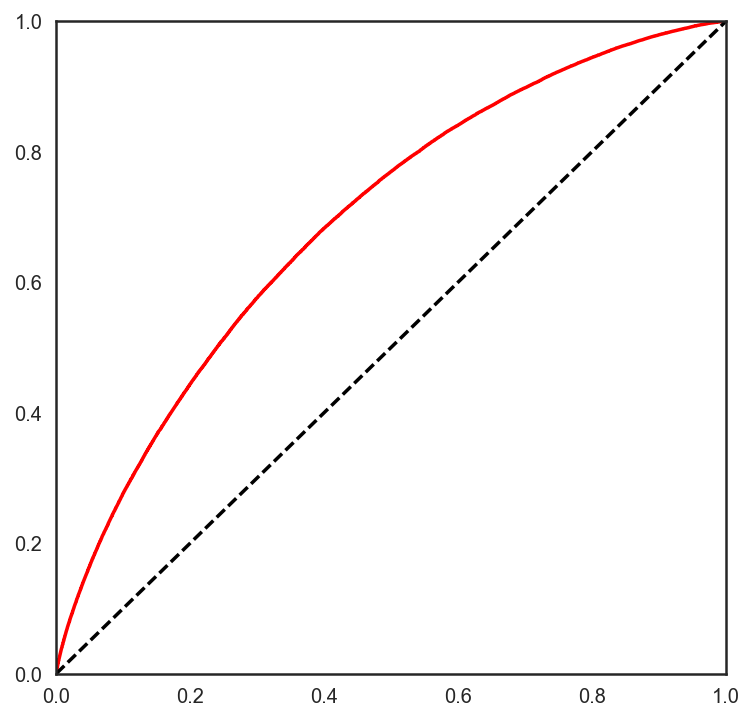

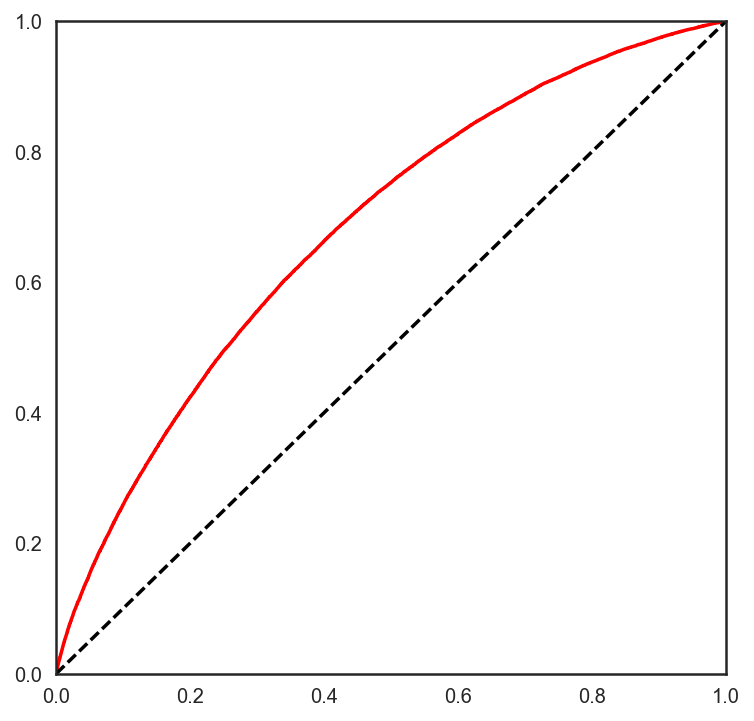

In [71]:
fpr, tpr, th = roc_curve(ally_true, ally_predp)
print(roc_auc_score(ally_true, ally_predp))

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

fpr, tpr, th = roc_curve(ally_trueV, ally_predpV)
print(roc_auc_score(ally_trueV, ally_predpV))

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))